<a href="https://colab.research.google.com/github/sovb/Garbage-Classification/blob/main/Garbage_Classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import os
import keras
import tensorflow as tf
import random,os,glob
from sklearn.metrics import confusion_matrix
#added by sovra
import scipy
from scipy import *
import skimage
from skimage import filters
from skimage import io 
import matplotlib.pyplot as plt  #added by sovra
import pandas as pd
import numpy as np
import zipfile as zf
import shutil
import re
import seaborn as sns
import random


In [3]:
dir_path = "/content/drive/MyDrive/Colab Notebooks/dataset-resized"

img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))
len(img_list)

2527

comment: maybe after performing the training, we can try gaussian blur to see if it makes a difference

In [4]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255)

test=ImageDataGenerator(rescale=1./255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(256,256),
                                          batch_size=32,
                                          color_mode="rgb",
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(256,256),
                                        batch_size=32,
                                        color_mode="rgb",
                                        class_mode='categorical',
                                        subset='validation')



labels = (train_generator.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

In [6]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [7]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(256,256,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.woo"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) 


In [10]:
history = model.fit_generator(train_generator,
                              epochs=40,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                              callbacks=callbacks_list) 
#41 epoch - 75% #73- 76.9%
#78 epoch - 80%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/40
71/71 [==============================] - ETA: 0s - loss: 1.6722 - accuracy: 0.2807
Epoch 1: val_accuracy improved from -inf to 0.35714, saving model to trained_model.woo
INFO:tensorflow:Assets written to: trained_model.woo/assets
71/71 [==============================] - 372s 5s/step - loss: 1.6722 - accuracy: 0.2807 - val_loss: 1.5269 - val_accuracy: 0.3571
Epoch 2/40
71/71 [==============================] - ETA: 0s - loss: 1.4940 - accuracy: 0.3730
Epoch 2: val_accuracy did not improve from 0.35714
71/71 [==============================] - 336s 5s/step - loss: 1.4940 - accuracy: 0.3730 - val_loss: 1.4555 - val_accuracy: 0.3571
Epoch 3/40
71/71 [==============================] - ETA: 0s - loss: 1.3958 - accuracy: 0.4247
Epoch 3: val_accuracy improved from 0.35714 to 0.47768, saving model to trained_model.woo
INFO:tensorflow:Assets written to: trained_model.woo/assets
71/71 [==============================] - 336s 5s/step - loss: 1.3958 - accuracy: 0.4247 - val_loss: 1.3324 - v

Maximum Probability:  0.9866829
Classified: plastic


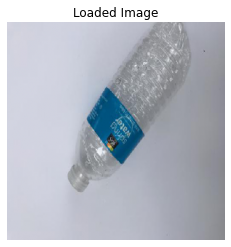

In [11]:
from keras.preprocessing import image

img_path = '/content/drive/MyDrive/Colab Notebooks/dataset-resized/plastic/plastic75.jpg'

img = image.load_img(img_path, target_size=(256, 256))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


-------------------Individual Probability--------------------------------

CARDBOARD : 0.45 %
GLASS : 0.62 %
METAL : 0.16 %
PAPER : 0.07 %
PLASTIC : 98.67 %
TRASH : 0.03 %


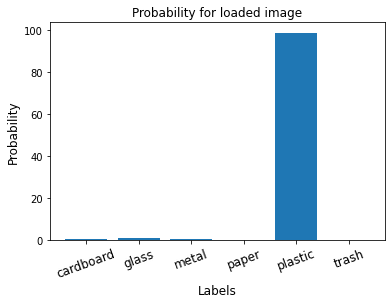

In [12]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

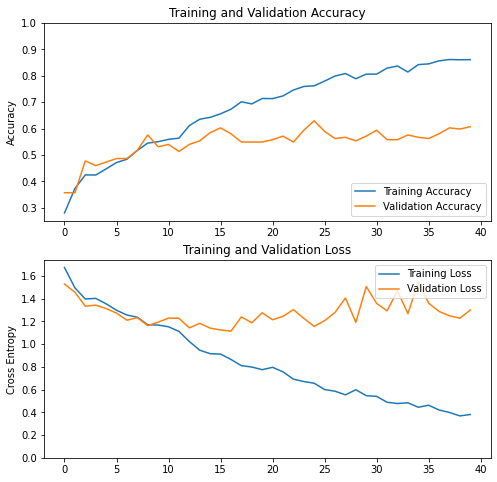

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()